In [1]:
import scipy.io
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

# Loading the data

In [2]:
data_path = "./data/"

ARDS_data = scipy.io.loadmat(data_path + "Ards.mat")
Control_data = scipy.io.loadmat(data_path + "Control.mat")

ARDS_data = {key: ARDS_data[key][0] for key in ["P", "Q", "V", "t"]}
Control_data = {key: Control_data[key][0] for key in ["P", "Q", "V", "t"]}

# Part 1 : make plots of the differents curves

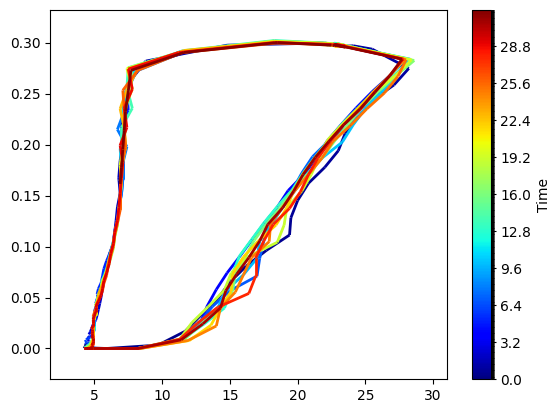

In [4]:
# Extracting data
X = Control_data['P']
Y = Control_data['V']
t = Control_data['t']

# Create a colormap that represents the gradient of time
cmap = plt.cm.jet  # You can choose any colormap you prefer
norm = plt.Normalize(min(t), max(t))
ncolors = len(t)  # Number of colors should match the number of time points
colors = cmap(norm(t))

# Create a list of segments for the LineCollection
points = np.array([X, Y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a LineCollection object with a color gradient
lc = LineCollection(segments, cmap=ListedColormap(colors), norm=BoundaryNorm(t, ncolors), linewidth=2)
lc.set_array(t)

# Plot the trajectory
fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)
plt.colorbar(lc, label='Time')
plt.show()

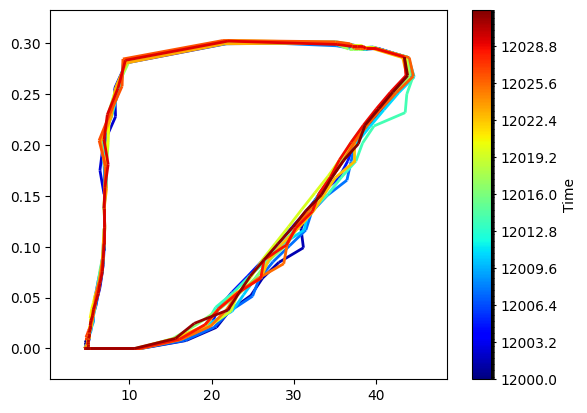

In [7]:
# Extracting data
X = ARDS_data['P']
Y = ARDS_data['V']
t = ARDS_data['t']

# Create a colormap that represents the gradient of time
cmap = plt.cm.jet  # You can choose any colormap you prefer
norm = plt.Normalize(min(t), max(t))
ncolors = len(t)  # Number of colors should match the number of time points
colors = cmap(norm(t))

# Create a list of segments for the LineCollection
points = np.array([X, Y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a LineCollection object with a color gradient
lc = LineCollection(segments, cmap=ListedColormap(colors), norm=BoundaryNorm(t, ncolors), linewidth=2)
lc.set_array(t)

# Plot the trajectory
fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)
plt.colorbar(lc, label='Time')
plt.show()